In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle
import bobsegutils as bsu

from skimage.draw import circle

import csv

from skimage import io

import math

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Load selected points

In [2]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
with open("/Users/prakash/Desktop/MarkGT/Choices.csv","r") as source:
    rdr= csv.reader( source )
    with open("/Users/prakash/Desktop/MarkGT/Choices_Structured.csv","w") as result:
        wtr= csv.writer( result )
        for r in rdr:
            wtr.writerow( (r[3], r[4]) )

### Load selected tracks

In [3]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
with open("/Users/prakash/Desktop/MarkGT/savedtracks.csv","r") as source:
    rdr= csv.reader( source )
    with open("/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv","w") as result:
        wtr= csv.writer( result )
        for r in rdr:
            wtr.writerow( (r[1], r[2]) )

### The manually tracked coordinates from Fiji are processed before plotting

In [4]:
def load_file(filename):
    '''Make a list of tuples from a csv file
    '''
    fp = open(filename, 'Ur')
    data_list = []
    for line in fp:
        data_list.append(tuple((line.strip().split(','))))
    fp.close()
    return data_list

In [5]:
starting_point_list = load_file("/Users/prakash/Desktop/MarkGT/Choices_Structured.csv")
starting_point_list_only_imp_rows = starting_point_list[1:] # Ignoring the header row (first row of csv file)
track_point_list = load_file("/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv")
track_point_list_only_imp_rows = track_point_list[1:] # Ignoring the header row (first row of csv file)

/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 'U' mode is deprecated


In [6]:
# The above created list elememts are string, we convert them to float below
starting_points = []
manual_track_points = []
float_starting_point_list = []
float_track_point_list = []

In [7]:
for element in range(len(starting_point_list_only_imp_rows)):
    number_element_starting_points = []
    number_element_track_points = []
    
    number_element_starting_points.append((float(starting_point_list_only_imp_rows[element][0])))
    number_element_starting_points.append((float(starting_point_list_only_imp_rows[element][1]))) 
    float_starting_point_list.append(tuple(number_element_starting_points))
    number_element_track_points.append((float(track_point_list_only_imp_rows[element][0])))
    number_element_track_points.append((float(track_point_list_only_imp_rows[element][1]))) 
    float_track_point_list.append(tuple(number_element_track_points))

In [8]:
starting_points.append(float_starting_point_list)
manual_track_points.append(float_track_point_list)

### Optical Flow computation 

In [9]:
filename = '/Users/prakash/Desktop/BobSegMarkData/2018-05-01_fromMark/MAX_C1-20180501_mNG-NMY-2_mSc-PH_01-01_Myosin.tif'
myosin_channel = imread(filename)
print('Shape of stack:', myosin_channel.shape)
sigma = [0.,2.,2.]
myosin_channel_smooth = gaussian(myosin_channel,sigma)

Shape of stack: (61, 836, 628)


In [10]:
flow_x, flow_y = bsu.compute_HornSchunckFlow(myosin_channel)
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

............................................................. ...done!


In [11]:
flow_x [1][200][300]

-0.723600786873095

In [12]:
flow_points = []
for frame, points in enumerate(starting_points):
    print(frame)
    flow_points_per_frame = []
    for i in range(len(points)):
        position = bsu.update_pos(points[i], 1, avg_flow_x, avg_flow_y )
        flow_points_per_frame.append(position)
    flow_points.append(flow_points_per_frame)

0


The cell below makes a flat list out of flow_points, maunal_track_points and center_points

In [13]:
starting_points_flat_list = [item for sublist in starting_points for item in sublist]
manual_track_points_flat_list = [item for sublist in manual_track_points for item in sublist]
flow_points_flat_list = [item for sublist in flow_points for item in sublist]

In [14]:
#cumulative_offset = 0
cumulative_relative_offset = 0
offset_list = []
relative_offset_list = []
for i in range(len(starting_points_flat_list)):
    offset = bsu.euclid_dist(manual_track_points_flat_list[i], flow_points_flat_list[i])
    r = bsu.euclid_dist(manual_track_points_flat_list[i], starting_points_flat_list[i])
    relative_offset = offset/r
    offset_list.append(offset)
    relative_offset_list.append(relative_offset)
    cumulative_relative_offset = cumulative_relative_offset + relative_offset

/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


In [15]:
inflist=[]
for ii in range(len(relative_offset_list)):
    if numpy.isinf(relative_offset_list[ii]):
        inflist.append(ii)

In [16]:
relative_offset_list[109]=0
print(relative_offset_list[109])

0


In [17]:
average_cumulative_relative_offset = cumulative_relative_offset / len(starting_points_flat_list)

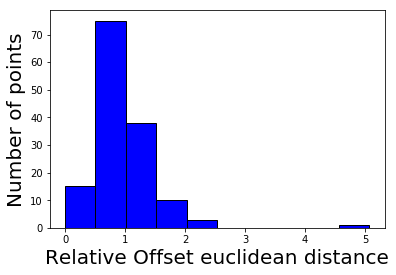

In [18]:
plt.hist(relative_offset_list,histtype='bar', color='blue', ec='black')
plt.xlabel('Relative Offset euclidean distance',fontsize=20)
plt.ylabel('Number of points',fontsize=20)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

### Flow Visualization Strategies and Computing and plotting results

In [19]:
center_to_manual_vectors = bsu.subVector(starting_points_flat_list, manual_track_points_flat_list)
center_to_flow_vectors = bsu.subVector(starting_points_flat_list, flow_points_flat_list)
delta = []
for i in range(len(center_to_manual_vectors)):
    angle_rad = bsu.angle_between( center_to_flow_vectors[i], center_to_manual_vectors[i])
    angle_deg = math.degrees(angle_rad)
    delta.append(angle_deg)

/Users/prakash/Git-repos/BoBSeg3D/BobSeg/AutomatedFlowParameters/bobsegutils.py:448: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


In [20]:
nanlist=[]
for ii in range(len(delta)):
    if numpy.isnan(delta[ii]):
        nanlist.append(ii)

In [21]:
print(nanlist)

[109]


In [22]:
delta[109]=0
print(delta[109])

0


In [23]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
with open("/Users/prakash/Desktop/MarkGT/savedtracks.csv","r") as source:
    rdr= csv.reader( source )
    with open("/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv","w") as result:
        wtr= csv.writer( result )
        for r in rdr:
            wtr.writerow( (r[3]) )

In [24]:
with open('/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv', 'r') as f:
    reader = csv.reader(f)
    uncertainty_radius_list = list(reader)
uncertainty_radius_list = uncertainty_radius_list[1:]
# print(uncertainty_radius_list)

uncertainty_radius_list=np.array(uncertainty_radius_list,integer)
uncertainty_radius_list = [item for sublist in uncertainty_radius_list for item in sublist]

In [25]:
pixel_lag = []
relative_pixel_lag = []
count = 0
for i in range(len(starting_points_flat_list)):
    if(bsu.euclid_dist(flow_points_flat_list[i], manual_track_points_flat_list[i])<= uncertainty_radius_list[i]) & (delta[i]<=45):
        
        position_offset = 0
        relative_position_offset = 0
        count = count +1
    else:
        r2 = bsu.euclid_dist(starting_points_flat_list[i], flow_points_flat_list[i])
        r1 = bsu.euclid_dist(starting_points_flat_list[i], manual_track_points_flat_list[i])
        position_offset = r2-r1
        relative_position_offset = abs(position_offset)/r1
        
    
    pixel_lag.append(position_offset)
    relative_pixel_lag.append(relative_position_offset*100)

In [26]:
print(count)

9


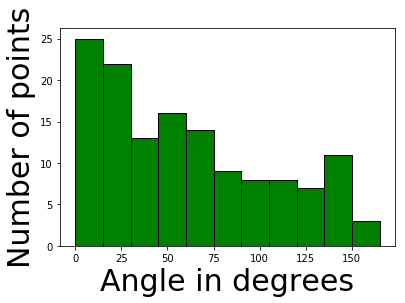

In [27]:
plt.hist(delta[1:], bins=range(0,180,15),histtype='bar', color='green', ec='black')
plt.xlabel('Angle in degrees',fontsize=30)
plt.ylabel('Number of points',fontsize=30)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

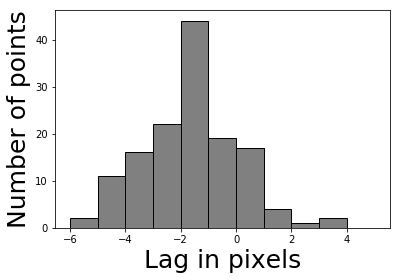

In [28]:
plt.hist(pixel_lag, bins=range(-6,6,1),histtype='bar', color='gray', ec='black')
plt.xlabel('Lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

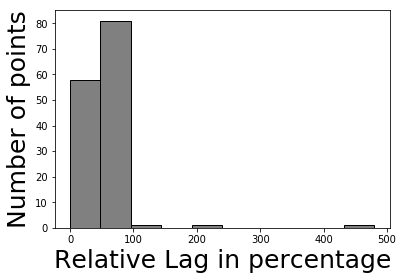

In [29]:
plt.hist(relative_pixel_lag, histtype='bar', color='gray', ec='black')
plt.xlabel('Relative Lag in percentage',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

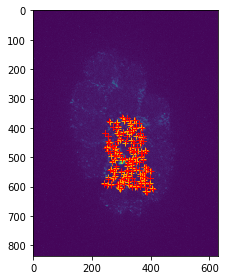

In [30]:
fig = plt.figure()
for element in range(len(starting_points_flat_list)):
#     plt.plot(starting_points_flat_list[element][0],starting_points_flat_list[element][1],'o',color='white') #Starting position
    plt.plot(manual_track_points_flat_list[element][0],manual_track_points_flat_list[element][1],'+',color='orange') #Updated position by flow computation
    plt.plot(flow_points_flat_list[element][0],flow_points_flat_list[element][1],'+',color='red') #Updated position by flow computation
    plt.imshow(myosin_channel[-1]) 
    fig.tight_layout()    

In [31]:
print(np.median(pixel_lag))
print(np.median(relative_pixel_lag))
print(np.percentile(pixel_lag, 75))
print(np.percentile(relative_pixel_lag,75))

-1.591631876980851
55.84215709019021
-0.5997990764124724
74.74791221593395


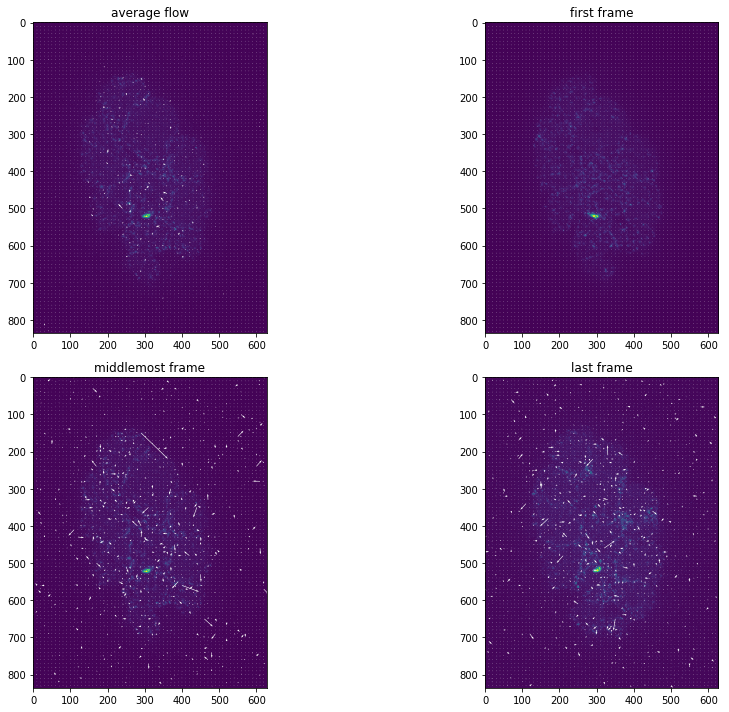

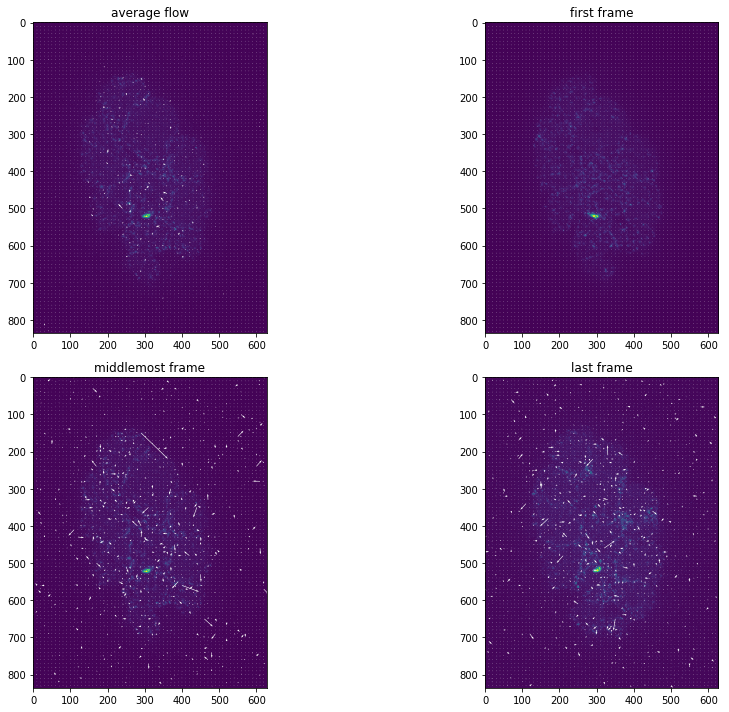

In [32]:
bsu.sanity_check_flow(figsize=(15,10), somechannel=myosin_channel, flow_x=flow_x, flow_y=flow_y)